In [1]:
import tools as cpg
import rasterio as rs
from rasterio.mask import mask

import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas as gpd
import pandas as pd

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

def getHUC4(HUC12):
    return HUC12[:4]

def getToHUC4(toHUC12):
    return toHUC12[:4]

def makePourBasins(wbd,fromHUC4,toHUC4):
    '''Make geodataframe of HUC12 basis flowing from fromHUC4 to toHUC4.
    
    Parameters
    ----------
    wbd : geodataframe
        HUC12-level geodataframe projected to the same CRS as the FAC and FDR grids being used.
    fromHUC4 : str
        HUC4 string for the upstream basin.
    toHUC4 : str
        HUC string for the downstream basin.
        
    Returns
    -------
    pourBasins : geodataframe
        HUC12-level geodataframe of units that drain from fromHUC4 to toHUC4.
    '''
    
    wbd['HUC4'] = wbd.HUC12.map(getHUC4)
    wbd['ToHUC4'] = wbd.ToHUC.map(getToHUC4)
    
    return wbd.loc[(wbd.HUC4 == fromHUC4) & (wbd.ToHUC4 == toHUC4)].copy()

In [2]:
WBDfl = '../../gis_data/WBD_10_HU2_GDB/WBD_10_HU2_GDB.gdb'
layer = 'WBDHU12'

tmp = gpd.read_file(WBDfl, layer = layer)
wbd = tmp.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")

In [3]:
wbd['HUC4'] = wbd.HUC12.map(getHUC4)
wbd['ToHUC4'] = wbd.ToHUC.map(getToHUC4)

In [4]:
hu1002 = wbd.loc[wbd.HUC4 == '1002']

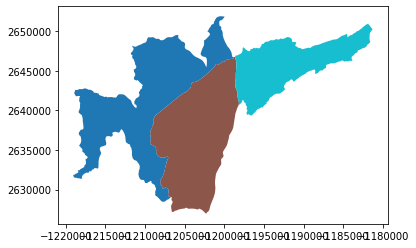

In [5]:
pourBasins = hu1002.loc[hu1002.ToHUC4 != '1002'].copy()
pourBasins.plot('HUC12');

In [6]:
pourBasins['Name']

2945      City of Three Forks-Madison River
3319               Rey Creek-Gallatin River
3868    City of Three Forks-Jefferson River
Name: Name, dtype: object

In [7]:

def findPourPoints(pourBasins, upfacfl, upfdrfl, plotBasins = False):
    '''Finds unique pour points between two HUC4s.
    
    Parameters
    ----------
    pourBasins : geodataframe
        Geodataframe of the HUC12 basins that flow into the downstream HUC4. Used to clip the upstream FAC grid to identify pour points.
    upfacfl : str (path)
        Path to the upstream flow accumulation grid.
    upfdrfl : str (path)
        Path to the upstream tauDEM flow direction grid.
    plotBasins : bool (False)
        Boolean to make plots of upstream HUC12s and identified pour points.
        
    Returns
    -------
    finalPoints : list
        List of tuples containing (x,y,w).
    '''
    pourPoints = []
    for i in range(len(pourBasins)):
        data = rs.open(upfacfl) # open the FAC grid

        # make a shape out of the HUC boundary
        row = pourBasins.iloc[[i]].copy()
        row['geometry'] = row.buffer(50)

        coords = getFeatures(row)

        out_img, out_transform = mask(data, shapes=coords, crop=True) # get the raster for the HUC

        cx,cy = np.where(out_img[0] == out_img[0].max()) # find the location of max values

        w = out_img[0].max() # get the value to propagate to the downstream grid.

        newx,newy = rs.transform.xy(out_transform,cx,cy) # convert the row, column locations to coordinates given the new affine

        # zip the coordinates to points, when moved downstream, only one of these should land on a no data pixel
        points = [(nx,ny) for nx,ny in zip(newx,newy)]

        # test if a point lands on a noData pixel.
        for point in points:
            x,y = point
            d = queryPoint(x,y,upfdrfl)
            newx,newy = FindDownstreamCellTauDir(d,x,y,out_transform[0])

            if queryPoint(newx,newy,upfacfl) == data.meta['nodata']:
                pourPoints.append((x,y,w)) # keep the point if it does.
    
    if plotBasins:
        ax = pourBasins.plot('Name')
        for px,py,pw in pourPoints:
            ax.scatter(px,py,c='k',s=20)
    
    # get the unique pour points...
    xs,ys,ws = zip(*pourPoints)

    xs = np.array(xs)
    ys = np.array(ys)
    ws = np.array(ws)

    pts = []
    for x,y,w in zip(xs,ys,ws):
        pts.append("%s%s%s"%(x,y,w))

    idx = np.unique(pts,return_index=True)[1]
    
    # use the indicies to make a set of final pour points
    finalPoints = []
    for x,y,w in zip(xs[idx],ys[idx],ws[idx]):
        finalPoints.append((x,y,w))
        
    return finalPoints

In [8]:
finalPoints = findPourPoints(pourBasins,upfacfl, upfdrfl, plotBasins=True)

NameError: name 'upfacfl' is not defined

In [ ]:
finalPoints

In [ ]:
upstream = '1002' # upstream hydrologic region
downstream = '1003' # downstream hydrologic region

In [ ]:
upfdrfl = '../data/cascade_data/%s/tauFDR.tif'%upstream
dwnfdrfl = '../data/cascade_data/%s/tauFDR.tif'%downstream

if not os.path.exists(upfdrfl):
    cpg.tauDrainDir('../data/cascade_data/%s/fdr.tif'%upstream, upfdrfl)
if not os.path.exists(dwnfdrfl):
    cpg.tauDrainDir('../data/cascade_data/%s/fdr.tif'%downstream, dwnfdrfl)

In [ ]:
# upstream files
upfacfl = '../data/cascade_data/%s/fac.tif'%(upstream)

# downstream files
dwnfacfl = '../data/cascade_data/%s/fac.tif'%(downstream)

dwnnewfacsrcfl = '../data/cascade_data/%s/fac_weight.tiff'%(downstream) # file path for the weighting grid for 
dwnnewfacfl = '../data/cascade_data/%s/fac_corr.tiff'%(downstream) # filepath for the corrected FAC.

In [10]:
cpg.tauFlowAccum(upfdrfl,upfacfl,cores=6)
cpg.tauFlowAccum(dwnfdrfl,dwnfacfl, cores=6)

Accumulating Data...
mpiexec -bind-to rr -n 6 aread8 -p ../data/cascade_data/1002/tauFDR.tif -ad8 ../data/cascade_data/1002/fac.tif -nc
Accumulating Data...
mpiexec -bind-to rr -n 6 aread8 -p ../data/cascade_data/1003/tauFDR.tif -ad8 ../data/cascade_data/1003/fac.tif -nc


In [9]:
def loadRaster(fl, returnMeta = False):
    try:
        with rs.open(fl) as src:
            dat = src.read(1)
            meta = src.meta.copy()
        
        if returnMeta:
            return dat, meta
        else:
            return dat
    except:
        print("Unable to open %s"%(fl))

In [10]:
def findLastFACFD(facfl, fl):
    '''Find the coordinate of the greatest FAC cell, return the value from the upfl at that point.
    
    This can be used to find the flow direction of the FAC cell with the greatest accumulation, or the parameter value.
    
    Parameters
    ----------
    facfl : str (path)
        Upstream FAC grid
    fl : str (path)
        Upstream 
    
    Returns
    -------
    x : float
        Horizontal coordinate of the greatest FAC cell.
    y : float
        Vertical coordinate of the greatest FAC cell.
    d : int or float
        Value from the parameter grid queried.
    w : float
        Cell size of the grid.
    '''
    
    fac,meta = loadRaster(facfl,returnMeta=True) # load the fac file
    dat = loadRaster(fl) # load the data file
    
    cx,cy = np.where(fac==fac.max()) # find the column, row cooridnates of the max fac.
    print("%s,%s"%(cx,cy))
    d = dat[cx,cy][0] # query the parameter grid
    
    src = rs.open(facfl) # open the fac dataset
    x,y = src.xy(cx,cy) # convert the column, row coordinates to map coordinates
    
    w = meta['transform'][0] # get the cell size of the grid
    
    return x[0],y[0],d,w

def queryPoint(x,y,grd):
    '''Query grid based on a supplied point.
    
    Parameters
    ----------
    x : float
        Horizontal coordinate in grd projection.
    y : float
        Vertical coordinate in grd projection.
    grd : str (path)
        Path to raster to query based on the supplied x and y.
        
    Returns
    -------
    value : float or int
        Value queried from the raster.
    '''
    
    with rs.open(grd) as src:
        for i in src.sample([(x,y)],1):
            return i[0]

In [11]:
def FindDownstreamCellTauDir(d,x,y,w):
    '''Find downstream cell given the flow direction of a cell using TauDEM directions.
    
    Parameters
    ----------
    d : int
        Flow direction of cell to find downstream cell of.
    x : float
        Horizontal coordinate (either projected or unprojected).
    y : float
        Vertical coordinate (either projected or unprojected).
    w : float
        Cell size in map units.
        
    Returns
    -------
    x : float
        Horizontal coordinate of the downstream cell.
    y : float
        Verital coordinate of the downstream cell.
    '''
    
    # figure out how to correct the point location
    if d == 1: # east
        dx = w
        dy = 0.
    elif d == 2: # northeast
        dx = w
        dy = w
    elif d == 3: # north
        dx = 0.
        dy = w
    elif d == 4: # northwest
        dx = w*-1.
        dy = w
    elif d == 5: # west
        dx = w*-1.
        dy = 0.
    elif d == 6: # southwest
        dx = w*-1.
        dy = w*-1.
    elif d == 7: # south
        dx = 0.
        dy = w*-1.
    elif d == 8: # southeast
        dx = w
        dy = w*-1.
        
    # update the location
    newX = x+dx
    newY = y+dy
    
    return newX,newY

In [12]:
import json

# Make it work for Python 2+3 and with Unicode
import io
try:
    to_unicode = unicode
except NameError:
    to_unicode = str

def saveJSON(dictionary, outfl):
    '''Save dictionary to JSON file.
    
    Parameters
    ----------
    dictionary : dict
        Dictionary to be saved.
    outfl : str (path)
        Path for where to generate the JSON
        
    Returns
    -------
    None
    '''
    # Write JSON file
    with io.open(outfl, 'w', encoding='utf8') as outfile:
        str_ = json.dumps(dictionary,
                      indent=4, sort_keys=True,
                      separators=(',', ': '), ensure_ascii=False)
        outfile.write(to_unicode(str_))
    
    return None

def loadJSON(infl):
    '''Load dictionary stored in a JSON file.
    
    Parameters
    ----------
    infl : str (path)
        Path to the JSON to be loaded.
        
    Returns
    -------
    dictionary : dict
        Dictionary that was loaded.
    '''
    # Read JSON file
    with open(infl) as data_file:
        dictionary = json.load(data_file)
    
    return dictionary

In [13]:
def createUpdateDict(x, y, upstreamFACmax, fromHUC, outfl):
    '''Create a dictionary for updating downstream FAC and parameter grids using values pulled from the next grid upstream.
    
    Parameters
    ----------
    x : list
        Horizontal coordinate(s) for where the update needs to happen in the downstream grid. 
    y : list
        Vertical coordinate(s) for where the update needs to happen in the downstream grid.
    upstreamFACmax : list
        Value(s) to insert into the downstream FAC grid.
    fromHUC : str
        The upstream HUC that the values are coming from.
    outfl : str (path)
        Path to where to save the json of this dictionary. The convention is to name this by the downstream HUC.
    
    Returns
    -------
    updateDict : dict
        Update dictionary
    
    Outputs
    -------
    updateDict : json (dict)
        Update dictionary saved to a json at outfl.
    '''
    
    # using lists instead of single values in case there are multiple pour points between basins
    
    # convert lists to strings
    xs = [str(xx) for xx in x]
    ys = [str(yy) for yy in y]
    facs = [str(fac) for fac in upstreamFACmax]
    
    subDict = { # make dictionary for the upstream FAC
        'x': xs,
        'y': ys,
        'maxUpstreamFAC':facs,
        'vars':['maxUpstreamFAC'] # list of contained variables
                }
    
    if os.path.exists(outfl): # if the update dictionary exists, update it.
        print('Update dictionary found: %s'%outfl)
        updateDict = loadJSON(outfl)
        print('Updating dictionary...')
        updateDict[fromHUC] = subDict
    else:
        updateDict = {
            fromHUC : subDict
        }
        
    saveJSON(updateDict, outfl)
    
    return updateDict

In [14]:
def updateRaster(x,y,val,grd,outgrd):
    '''Insert val into grd as location specified by x,y, writes to outgrd.
    
    Parameters
    ----------
    x : list or float
    y : list of float
        Vertical coordinate in map
    val : int or float
        Value to insert into grd
    grd : str (path)
        File path to read grd to update from.
    outgrd : str (path)
        File path to write output to.
    
    Returns
    -------
    None
    
    Output
    ------
    dat : raster
        Writes raster dataset to supplied grdout destination.
    '''
    
    if type(x) != list:
        x = list(x)
        
    if type(y) != list:
        y = list(y)
        
    if type(val) != list:
        val = list(val)
    
    dat,meta = loadRaster(grd, returnMeta=True)
    
    with rs.open(grd) as src: # iterate over the supplied points 
        for xx,yy,vv in zip(x,y,val):
            c,r = src.index(float(xx),float(yy)) # get column, row coordinates
            dat[c,r] = int(float(vv)) # update the dataset
            
    meta.update({
        'compress':'LZW',
        'profile':'GeoTIFF',
        'tiled':True,
        'sparse_ok':True,
        'num_threads':'ALL_CPUS',
        'bigtiff':'IF_SAFER',
        'driver' : "GTiff"
    })
            
    with rs.open(outgrd,'w',**meta) as dst: # open dataset for output
        dst.write(dat,1)
    
    return None

def makeFACweight(ingrd,outWeight):
    '''Make FAC weighting grid of ones based on the extents of the input grid. No data cells are persisted.
    
    Parameters
    ----------
    ingrd : str (path)
    outWeight : str (path)
    
    Returns
    -------
    None
    
    Output
    ------
    outWeight : raster
        Raster of the same extent and resolution as the input grid, but filled with ones where data exist. 
        No data cells are persisted.
    '''
    dat, meta = loadRaster(ingrd, returnMeta=True)
    
    ones = np.ones_like(dat, dtype=np.int32) # make a grid of ones shaped like the original FAC grid. These will be used
    # as a weighting grid that can be corrected.
    
    ones[dat == meta['nodata']] = meta['nodata'] # persist the noData value into the grid
    meta['dtype'] = ones.dtype # update the datatype
    meta.update({
        'compress':'LZW',
        'profile':'GeoTIFF',
        'tiled':True,
        'sparse_ok':True,
        'num_threads':'ALL_CPUS',
        'bigtiff':'IF_SAFER',
        'driver' : "GTiff"
    })
    
    with rs.open(outWeight,'w',**meta) as dst:
        dst.write(ones,1)
    
    return None

In [15]:
# Test finding facMAX and output to JSON

updateDictFl = '../data/cascade_data/%s/updateDict.json'%downstream

#x,y,d,w = findLastFACFD(upfacfl, upfdrfl) # get the fdr value
#maxFAC = queryPoint(x,y,upfacfl) # get the maxFAC 
#newX,newY = FindDownstreamCellTauDir(d,x,y,w) # find the most upstream downstream cell.
pourBasins = makePourBasins(wbd,'1002','1003')
pourPoints = findPourPoints(pourBasins,upfacfl, upfdrfl, plotBasins = True)
newX,newY,maxFAC = zip(*pourPoints)
createUpdateDict(list(newX),list(newY),list(maxFAC),upstream,updateDictFl)

NameError: name 'downstream' is not defined

In [16]:
downstreamFACweightFl = "../data/cascade_data/%s/facWeight.tif"%(downstream)
downstreamFACFl = "../data/cascade_data/%s/fac.tif"%(downstream)

def adjustFAC(facWeighttemplate, downstreamFACweightFl, updateDictFl, downstreamFDRFl, adjFACFl, cores=1):
    '''Generate updated FAC given an update dictionary.
    
    Parameters
    ----------
    facWeighttemplate : str (path)
        Path to a FDR or FAC grid used to make the FAC weighting grid.
    downstreamFACweightFl : str (path)
        Path to output the FAC weighting grid.
    updateDictFl : str (path)
        Path to update dictionary used to update the FAC weighting grid.
    downstreamFDRFl : str (path)
        Path to downstream FDR to use when computing the adjusted FAC grid.
    adjFACFl : str (path)
        Path to output adjusted FAC grid.
    cores : int (default 1)
        Number of cores to run 
    
    Returns
    -------
    
    Outputs
    -------
    adjFACFl : raster
        Adjusted flow accumulation raster
    
    '''
    updateDict = loadJSON(updateDictFl)
    for key in updateDict.keys(): # for each upstream HUC.

        upstreamDict = updateDict[key] # subset out the upstream HUC of interest
        if 'maxUpstreamFAC' in upstreamDict['vars']:
            if not os.path.isfile(downstreamFACweightFl): # If weighting file not present, create one at the supplied path.
                print("Generating FAC weighting grid.")
                makeFACweight(facWeighttemplate,downstreamFACweightFl) 
            if os.path.isfile(downstreamFACweightFl): # if the weighting grid is present, update it with the upstream value.
                print("Updating FAC weighting grip with value from %s FAC"%(key))
                updateRaster(upstreamDict['x'],
                             upstreamDict['y'],
                             upstreamDict['maxUpstreamFAC'],
                             downstreamFACweightFl,downstreamFACweightFl) # update with lists
            
    cpg.accumulateParam(downstreamFACweightFl, downstreamFDRFl, adjFACFl, cores = cores) # run a parameter accumulation on the weighting grid.

NameError: name 'downstream' is not defined

In [196]:
adjustFAC(downstreamFACFl,dwnfdrfl,updateDictFl,dwnfdrfl,'../data/cascade_data/1003/FACadj.tif', cores=6)

Updating FAC weighting grip with value from 1002 FAC
0.0
Accumulating Data...
mpiexec -bind-to rr -n 6 aread8 -p ../data/cascade_data/1003/tauFDR.tif -ad8 ../data/cascade_data/1003/FACadj.tif -wg ../data/cascade_data/1003/tauFDR.tif -nc


In [194]:
cpg.accumulateParam(downstreamFACweightFl,dwnfdrfl,'../data/cascade_data/1003/FACadj.tif',cores=6)

0.0
Accumulating Data...
mpiexec -bind-to rr -n 6 aread8 -p ../data/cascade_data/1003/tauFDR.tif -ad8 ../data/cascade_data/1003/FACadj.tif -wg ../data/cascade_data/1003/facWeight.tif -nc


In [ ]:
def updateDict(ud, upHUC, varName, val):
    '''Update dictionary with parameter value.
    
    Parameters
    ----------
    ud : dict
        Update dictionary to add a variable to.
    upHUC : str
        Name of the upstream HUC that the variable cooresponds to.
    varName : str
        Name to use for the variable.
    val : list or int or float
        Value to add to the upstream dictonary.
    
    Returns
    -------
    None
    
    Outputs
    -------
    ud : dict (JSON)
        Update dictionary written back out to file.
    '''
    
    if type(val) != list:
        val = list(val)
    
    UD = loadJSON(ud)
    
    upstream = UD[upHUC]
    variables = upstream['vars']
    variables.append(varName)
    upstream['vars'] = variables
    
    upstream[varName] = val
    
    UD[upHUC] = upstream # update dictionary with upstream sub-dictionary
    saveJSON(ud) # write out file
    

In [ ]:
def adjustParam(updatedParam, downstreamParamFL, updateDictFl, adjParamFl):
    '''Generate updated FAC given an update dictionary.
    
    Parameters
    ----------
    updatedParam : str
        Name of the parameter to update.
    downstreamParamFL : str (path)
        Path to downstream parameter grid to update.
    updateDictFl : str (path)
        Path to update dictionary to use.
    adjParamFl : str (path)
        Path to output adjusted parameter file.
    
    Returns
    -------
    None
    
    Outputs
    -------
    adjParamFl : raster
        Adjusted parameter file that can be accumulated prior to CPG creation.
    '''
    updateDict = loadJSON(updateDictFl)
    for key in updateDict.keys(): # for each upstream HUC.

        upstreamDict = updateDict[key] # subset out the upstream HUC of interest
        if updatedParam in upstreamDict['vars']: 
            if os.path.isfile(downstreamParamFL): # if the weighting grid is present, update it with the upstream value.
                print("Updating parameter grid with value from %s FAC"%(key))
                updateRaster(upstreamDict['x'],
                             upstreamDict['y'],
                             upstreamDict[updatedParam],
                             downstreamParamFL,adjParamFl) # update with lists